In [524]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from sklearn import linear_model
from sklearn import model_selection
from sklearn import feature_selection
%matplotlib inline

## Датасет - рейтинги компьютерных игр

Вам нужно построить логистическую регрессию для предсказания рейтинга игры по специальной шкале (будем считать для простоты, что рейтинги закодированы определенным образом). Распределение значений таргета Rating представлено ниже.

In [480]:
df_sales = pd.read_csv('video_games_sales.csv')

#### Распределение таргета

<AxesSubplot:xlabel='Rating', ylabel='cnt'>

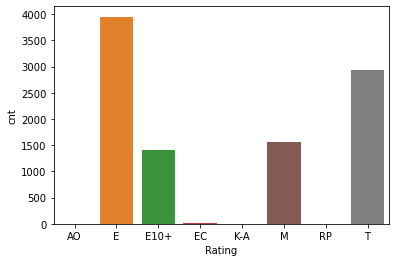

In [481]:
df_sales_gr = df_sales.groupby('Rating').agg({'User_Score': 'count'})
sns.barplot(x='Rating', y='cnt', data=pd.DataFrame(np.concatenate((np.array(df_sales_gr.index).reshape(-1, 1), df_sales_gr.values), axis=1), columns=['Rating', 'cnt']))

In [482]:
df_sales

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


## Задание 1

Определите, какие из признаков в датасете категориальные, порядковые, непрерывные. Выпишите признак и его тип ниже

Platform - категориальный признак
Year_of_Release -  непрерывные признак
Genre - категориальный признак
Publisher - порядковые признак
Developer - порядковые признак
NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales -  непрерывные признак
Critic_Score, Critic_Count, User_Score, User_Count - -  непрерывные признак

Как распределяются непрерывныеу признаки? Постройте графики их распределений. Проведите тест на нормальность распределения для двух выбранных вами признаков. Какое получилось p-value? Что это значит?

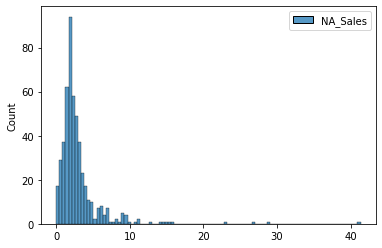

ShapiroResult(statistic=0.5439832210540771, pvalue=5.367239706764889e-34)
(значение статистики, p-value)
ShapiroResult(statistic=0.5439832210540771, pvalue=5.367239706764889e-34)


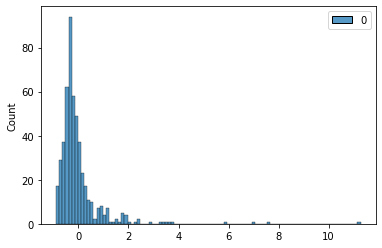

In [483]:
data = df_sales[['NA_Sales']].head(500)
sns.histplot(data)
plt.show()
print(stats.shapiro(data))
print("(значение статистики, p-value)")

sns.histplot(preprocessing.StandardScaler().fit_transform(data))
print(stats.shapiro(preprocessing.StandardScaler().fit_transform(data)))

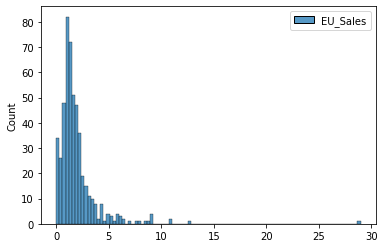

ShapiroResult(statistic=0.5887093544006348, pvalue=1.06935712917662e-32)
(значение статистики, p-value)
ShapiroResult(statistic=0.58870929479599, pvalue=1.0693449334227302e-32)


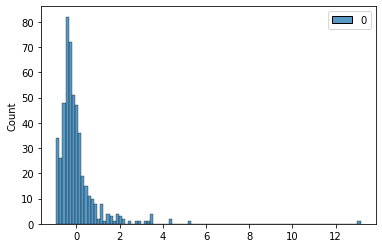

In [484]:
data = df_sales[['EU_Sales']].head(500)
sns.histplot(data)
plt.show()
print(stats.shapiro(data))
print("(значение статистики, p-value)")

sns.histplot(preprocessing.StandardScaler().fit_transform(data))
print(stats.shapiro(preprocessing.StandardScaler().fit_transform(data)))

p-value очень маленькое и при увличении количества данных p-value стремить к 0 в обоих случаях

## Задание 2

1. Как вы можете видеть, некоторые признаки имеют пропуски. Вам необходимо заполнить данные пропуски несколькими различными способами (среднее, медиана, мода). Заодно вспоминаем, что означает каждый из терминов!  
2. Просто выбросите те строки, в которых есть хотя бы одно значение типа NaN. Сколько осталось строк после этого преобразования? Стоит ли применять подобный подход в данном случае?
3. Отдельно прошу подумать над случаями, когда NaN стоит в целевом параметре. Что будете делать с этими строками?

In [485]:
df_sales.shape[0]

16719

In [486]:
df_sales.dropna().shape[0]

6825

Количество строк без Nan стало в 3 раза меньше, чтотне хорошо для обучения модели. Такой подход не очень хорош

In [487]:
df_sales.info

<bound method DataFrame.info of                                 Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16714  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16715               LMA Manager 2007     X360           2006.0        Sports   
16716        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16717               Spirits & Spells      GBA           2003.0      Platform   
16718            Winning Post 8 2016      PSV           2016.0    Simulation   

       

In [488]:
df_sales = df_sales.fillna(df_sales.mean())

In [489]:
df_sales['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [490]:
df_sales.loc[df_sales['User_Score']=='tbd', 'User_Score'] = 0

In [491]:
df_sales['User_Score'] = df_sales['User_Score'].astype(float)

In [492]:
df_sales['User_Score'].apply(lambda x : print(type(x)))

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

0        None
1        None
2        None
3        None
4        None
         ... 
16714    None
16715    None
16716    None
16717    None
16718    None
Name: User_Score, Length: 16719, dtype: object

In [493]:
df_sales['User_Score'] = df_sales['User_Score'].fillna(df_sales['User_Score'].mean())

In [494]:
df_sales['User_Score'].unique()

array([8.        , 5.39981028, 8.3       , 8.5       , 6.6       ,
       8.4       , 8.6       , 7.7       , 6.3       , 7.4       ,
       8.2       , 9.        , 7.9       , 8.1       , 8.7       ,
       7.1       , 3.4       , 5.3       , 4.8       , 3.2       ,
       8.9       , 6.4       , 7.8       , 7.5       , 2.6       ,
       7.2       , 9.2       , 7.        , 7.3       , 4.3       ,
       7.6       , 5.7       , 5.        , 9.1       , 6.5       ,
       0.        , 8.8       , 6.9       , 9.4       , 6.8       ,
       6.1       , 6.7       , 5.4       , 4.        , 4.9       ,
       4.5       , 9.3       , 6.2       , 4.2       , 6.        ,
       3.7       , 4.1       , 5.8       , 5.6       , 5.5       ,
       4.4       , 4.6       , 5.9       , 3.9       , 3.1       ,
       2.9       , 5.2       , 3.3       , 4.7       , 5.1       ,
       3.5       , 2.5       , 1.9       , 3.        , 2.7       ,
       2.2       , 2.        , 9.5       , 2.1       , 3.6    

In [495]:
df_sales['Developer'] = df_sales['Developer'].fillna('No name')

In [496]:
df_sales['Rating'] = df_sales['Rating'].fillna('No rating')

In [497]:
df_sales['Genre'] = df_sales['Genre'].fillna('No genre')

In [498]:
df_sales.info

<bound method DataFrame.info of                                 Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16714  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16715               LMA Manager 2007     X360           2006.0        Sports   
16716        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16717               Spirits & Spells      GBA           2003.0      Platform   
16718            Winning Post 8 2016      PSV           2016.0    Simulation   

       

## Задание 3

Теперь преобразуйте категориальные признаки в такой вид, который можно корректно подать на вход классификатору типа "Логистическая регрессия".

In [499]:
df_sales.values[:, [1]]

array([['Wii'],
       ['NES'],
       ['Wii'],
       ...,
       ['PSV'],
       ['GBA'],
       ['PSV']], dtype=object)

In [500]:
enc_2 = OneHotEncoder()
enc_2.fit(df_sales[['Platform']])
states = df_sales.values[:, [1]]
encoded_ds = enc_2.transform(states).toarray()

In [501]:
encoded_ds.shape

(16719, 31)

In [502]:
enc_2.get_feature_names()

array(['x0_2600', 'x0_3DO', 'x0_3DS', 'x0_DC', 'x0_DS', 'x0_GB', 'x0_GBA',
       'x0_GC', 'x0_GEN', 'x0_GG', 'x0_N64', 'x0_NES', 'x0_NG', 'x0_PC',
       'x0_PCFX', 'x0_PS', 'x0_PS2', 'x0_PS3', 'x0_PS4', 'x0_PSP',
       'x0_PSV', 'x0_SAT', 'x0_SCD', 'x0_SNES', 'x0_TG16', 'x0_WS',
       'x0_Wii', 'x0_WiiU', 'x0_X360', 'x0_XB', 'x0_XOne'], dtype=object)

In [503]:
pl_df = pd.DataFrame(encoded_ds,
             columns=enc_2.get_feature_names())
pl_df.head()

,x0_2600,x0_3DO,x0_3DS,x0_DC,x0_DS,x0_GB,x0_GBA,x0_GC,x0_GEN,x0_GG,...,x0_SAT,x0_SCD,x0_SNES,x0_TG16,x0_WS,x0_Wii,x0_WiiU,x0_X360,x0_XB,x0_XOne
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [504]:
df_sales_ = pd.concat((df_sales, pl_df), 
                         axis=1)

In [505]:
df_sales_

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,...,x0_SAT,x0_SCD,x0_SNES,x0_TG16,x0_WS,x0_Wii,x0_WiiU,x0_X360,x0_XB,x0_XOne
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [506]:
df_sales_ = pd.get_dummies(df_sales_, 
               columns=['Platform'])

In [507]:
df_sales_

,Name,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,...,Platform_SAT,Platform_SCD,Platform_SNES,Platform_TG16,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne
0,Wii Sports,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.000000,...,0,0,0,0,0,1,0,0,0,0
1,Super Mario Bros.,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,68.967679,...,0,0,0,0,0,0,0,0,0,0
2,Mario Kart Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.000000,...,0,0,0,0,0,1,0,0,0,0
3,Wii Sports Resort,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.000000,...,0,0,0,0,0,1,0,0,0,0
4,Pokemon Red/Pokemon Blue,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,68.967679,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,68.967679,...,0,0,0,0,0,0,0,0,0,0
16715,LMA Manager 2007,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,68.967679,...,0,0,0,0,0,0,0,1,0,0
16716,Haitaka no Psychedelica,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,68.967679,...,0,0,0,0,0,0,0,0,0,0
16717,Spirits & Spells,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,68.967679,...,0,0,0,0,0,0,0,0,0,0


In [508]:
df_sales_['Genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', 'No genre'], dtype=object)

In [509]:
df_sales_.values[:, [2]]

array([['Sports'],
       ['Platform'],
       ['Racing'],
       ...,
       ['Adventure'],
       ['Platform'],
       ['Simulation']], dtype=object)

In [510]:
enc_1 = OneHotEncoder()
enc_1.fit(df_sales_[['Genre']])
states = df_sales_.values[:, [2]]
encoded_ds = enc_1.transform(states).toarray()

In [511]:
encoded_ds.shape

(16719, 13)

In [512]:
enc_1.get_feature_names()

array(['x0_Action', 'x0_Adventure', 'x0_Fighting', 'x0_Misc',
       'x0_No genre', 'x0_Platform', 'x0_Puzzle', 'x0_Racing',
       'x0_Role-Playing', 'x0_Shooter', 'x0_Simulation', 'x0_Sports',
       'x0_Strategy'], dtype=object)

In [513]:
gn_df = pd.DataFrame(encoded_ds,
             columns=enc_1.get_feature_names())
gn_df.head()

,x0_Action,x0_Adventure,x0_Fighting,x0_Misc,x0_No genre,x0_Platform,x0_Puzzle,x0_Racing,x0_Role-Playing,x0_Shooter,x0_Simulation,x0_Sports,x0_Strategy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [514]:
df_sales_2 = pd.concat((df_sales_, gn_df), 
                         axis=1)

In [515]:
df_sales_2

,Name,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,...,x0_Misc,x0_No genre,x0_Platform,x0_Puzzle,x0_Racing,x0_Role-Playing,x0_Shooter,x0_Simulation,x0_Sports,x0_Strategy
0,Wii Sports,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Super Mario Bros.,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,68.967679,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Mario Kart Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Wii Sports Resort,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Pokemon Red/Pokemon Blue,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,68.967679,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,68.967679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16715,LMA Manager 2007,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,68.967679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16716,Haitaka no Psychedelica,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,68.967679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16717,Spirits & Spells,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,68.967679,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [516]:
df_sales_2 = pd.get_dummies(df_sales_, 
               columns=['Genre'])

In [517]:
df_sales_2

,Name,Year_of_Release,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,...,Genre_Misc,Genre_No genre,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,Wii Sports,2006.0,Nintendo,41.36,28.96,3.77,8.45,82.53,76.000000,51.000000,...,0,0,0,0,0,0,0,0,1,0
1,Super Mario Bros.,1985.0,Nintendo,29.08,3.58,6.81,0.77,40.24,68.967679,26.360821,...,0,0,1,0,0,0,0,0,0,0
2,Mario Kart Wii,2008.0,Nintendo,15.68,12.76,3.79,3.29,35.52,82.000000,73.000000,...,0,0,0,0,1,0,0,0,0,0
3,Wii Sports Resort,2009.0,Nintendo,15.61,10.93,3.28,2.95,32.77,80.000000,73.000000,...,0,0,0,0,0,0,0,0,1,0
4,Pokemon Red/Pokemon Blue,1996.0,Nintendo,11.27,8.89,10.22,1.00,31.37,68.967679,26.360821,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,2016.0,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,68.967679,26.360821,...,0,0,0,0,0,0,0,0,0,0
16715,LMA Manager 2007,2006.0,Codemasters,0.00,0.01,0.00,0.00,0.01,68.967679,26.360821,...,0,0,0,0,0,0,0,0,1,0
16716,Haitaka no Psychedelica,2016.0,Idea Factory,0.00,0.00,0.01,0.00,0.01,68.967679,26.360821,...,0,0,0,0,0,0,0,0,0,0
16717,Spirits & Spells,2003.0,Wanadoo,0.01,0.00,0.00,0.00,0.01,68.967679,26.360821,...,0,0,1,0,0,0,0,0,0,0


In [534]:
df_sales_2['Rating'].unique()

array(['E', 'No rating', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

In [536]:
df_sales_2.values[:, [13]]

array([['E'],
       ['No rating'],
       ['E'],
       ...,
       ['No rating'],
       ['No rating'],
       ['No rating']], dtype=object)

In [537]:
enc_ = LabelEncoder()
enc_.fit(df_sales_2[['Rating']])
states = df_sales_2.values[:, [13]]
encoded_ds = enc_.transform(states)

In [551]:
r_df = pd.DataFrame(encoded_ds)
r_df_ = r_df.rename(columns=lambda x:'Rating1')
r_df_.head()

,Rating1
0,1
1,6
2,1
3,1
4,6


In [557]:
df_sales_3 = pd.concat((df_sales_2, r_df_), 
                         axis=1)

In [558]:
df_sales_3

,Name,Year_of_Release,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,...,Genre_No genre,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Rating1
0,Wii Sports,2006.0,Nintendo,41.36,28.96,3.77,8.45,82.53,76.000000,51.000000,...,0,0,0,0,0,0,0,1,0,1
1,Super Mario Bros.,1985.0,Nintendo,29.08,3.58,6.81,0.77,40.24,68.967679,26.360821,...,0,1,0,0,0,0,0,0,0,6
2,Mario Kart Wii,2008.0,Nintendo,15.68,12.76,3.79,3.29,35.52,82.000000,73.000000,...,0,0,0,1,0,0,0,0,0,1
3,Wii Sports Resort,2009.0,Nintendo,15.61,10.93,3.28,2.95,32.77,80.000000,73.000000,...,0,0,0,0,0,0,0,1,0,1
4,Pokemon Red/Pokemon Blue,1996.0,Nintendo,11.27,8.89,10.22,1.00,31.37,68.967679,26.360821,...,0,0,0,0,1,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,2016.0,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,68.967679,26.360821,...,0,0,0,0,0,0,0,0,0,6
16715,LMA Manager 2007,2006.0,Codemasters,0.00,0.01,0.00,0.00,0.01,68.967679,26.360821,...,0,0,0,0,0,0,0,1,0,6
16716,Haitaka no Psychedelica,2016.0,Idea Factory,0.00,0.00,0.01,0.00,0.01,68.967679,26.360821,...,0,0,0,0,0,0,0,0,0,6
16717,Spirits & Spells,2003.0,Wanadoo,0.01,0.00,0.00,0.00,0.01,68.967679,26.360821,...,0,1,0,0,0,0,0,0,0,6


In [570]:
df_sales_3 = df_sales_3.drop(['Rating'], axis = 1)


In [571]:
df_sales_3.columns

Index(['Name', 'Year_of_Release', 'Publisher', 'NA_Sales', 'EU_Sales',
       'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'x0_2600',
       'x0_3DO', 'x0_3DS', 'x0_DC', 'x0_DS', 'x0_GB', 'x0_GBA', 'x0_GC',
       'x0_GEN', 'x0_GG', 'x0_N64', 'x0_NES', 'x0_NG', 'x0_PC', 'x0_PCFX',
       'x0_PS', 'x0_PS2', 'x0_PS3', 'x0_PS4', 'x0_PSP', 'x0_PSV', 'x0_SAT',
       'x0_SCD', 'x0_SNES', 'x0_TG16', 'x0_WS', 'x0_Wii', 'x0_WiiU', 'x0_X360',
       'x0_XB', 'x0_XOne', 'Platform_2600', 'Platform_3DO', 'Platform_3DS',
       'Platform_DC', 'Platform_DS', 'Platform_GB', 'Platform_GBA',
       'Platform_GC', 'Platform_GEN', 'Platform_GG', 'Platform_N64',
       'Platform_NES', 'Platform_NG', 'Platform_PC', 'Platform_PCFX',
       'Platform_PS', 'Platform_PS2', 'Platform_PS3', 'Platform_PS4',
       'Platform_PSP', 'Platform_PSV', 'Platform_SAT', 'Platform_SCD',
       'Platform_SNES', 'Platform_TG16', 'Platform_WS', 'Pla

## Задание 4

Нормализуйте непрерывные признаки с помощью функции StandardScaler (или RobustScaler, на выбор).
Используя функцию `cross_val_score` модуля `model_selection`, обучите логистическую регрессию. Для функции потерь можно использовать всё тот же `neg_log_loss` (отдельно разберем метрики на следующем занятии)

In [604]:
df_sales_3['Rating1'].unique()

array([1, 6, 5, 8, 2, 4, 0, 3, 7])

In [596]:
y_train = df_sales_3['Rating1']

In [584]:
x_train  = df_sales_3.drop(['Rating1','Name','Publisher','Developer'], axis = 1)

In [600]:
x_train

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,...,Genre_Misc,Genre_No genre,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,2006.0,41.36,28.96,3.77,8.45,82.53,76.000000,51.000000,8.00000,322.000000,...,0,0,0,0,0,0,0,0,1,0
1,1985.0,29.08,3.58,6.81,0.77,40.24,68.967679,26.360821,5.39981,162.229908,...,0,0,1,0,0,0,0,0,0,0
2,2008.0,15.68,12.76,3.79,3.29,35.52,82.000000,73.000000,8.30000,709.000000,...,0,0,0,0,1,0,0,0,0,0
3,2009.0,15.61,10.93,3.28,2.95,32.77,80.000000,73.000000,8.00000,192.000000,...,0,0,0,0,0,0,0,0,1,0
4,1996.0,11.27,8.89,10.22,1.00,31.37,68.967679,26.360821,5.39981,162.229908,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,2016.0,0.00,0.00,0.01,0.00,0.01,68.967679,26.360821,5.39981,162.229908,...,0,0,0,0,0,0,0,0,0,0
16715,2006.0,0.00,0.01,0.00,0.00,0.01,68.967679,26.360821,5.39981,162.229908,...,0,0,0,0,0,0,0,0,1,0
16716,2016.0,0.00,0.00,0.01,0.00,0.01,68.967679,26.360821,5.39981,162.229908,...,0,0,0,0,0,0,0,0,0,0
16717,2003.0,0.01,0.00,0.00,0.00,0.01,68.967679,26.360821,5.39981,162.229908,...,0,0,1,0,0,0,0,0,0,0


In [586]:
scaler = preprocessing.StandardScaler()

In [587]:
trans_data = scaler.fit_transform(x_train.values)

In [597]:
y_train.value_counts()

6    6769
1    3991
8    2961
5    1563
2    1420
3       8
7       3
4       3
0       1
Name: Rating1, dtype: int64

In [608]:
model_selection.cross_val_score(
    linear_model.LogisticRegression(), 
    trans_data, 
    y_train
).mean()

C:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lea

0.6102651294499541

## Задание 5

Обучите теперь просто на всем датасете логистическую регрессию разово (без использования `cross_val_score`). Определите по итогам обучения Логистической регрессии, какие из признаков являются самыми важными, а какие менее важными. Постройте график важности признаков (как строили на уроке).

In [645]:
x_train

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,...,Genre_Misc,Genre_No genre,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,2006.0,41.36,28.96,3.77,8.45,82.53,76.000000,51.000000,8.00000,322.000000,...,0,0,0,0,0,0,0,0,1,0
1,1985.0,29.08,3.58,6.81,0.77,40.24,68.967679,26.360821,5.39981,162.229908,...,0,0,1,0,0,0,0,0,0,0
2,2008.0,15.68,12.76,3.79,3.29,35.52,82.000000,73.000000,8.30000,709.000000,...,0,0,0,0,1,0,0,0,0,0
3,2009.0,15.61,10.93,3.28,2.95,32.77,80.000000,73.000000,8.00000,192.000000,...,0,0,0,0,0,0,0,0,1,0
4,1996.0,11.27,8.89,10.22,1.00,31.37,68.967679,26.360821,5.39981,162.229908,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,2016.0,0.00,0.00,0.01,0.00,0.01,68.967679,26.360821,5.39981,162.229908,...,0,0,0,0,0,0,0,0,0,0
16715,2006.0,0.00,0.01,0.00,0.00,0.01,68.967679,26.360821,5.39981,162.229908,...,0,0,0,0,0,0,0,0,1,0
16716,2016.0,0.00,0.00,0.01,0.00,0.01,68.967679,26.360821,5.39981,162.229908,...,0,0,0,0,0,0,0,0,0,0
16717,2003.0,0.01,0.00,0.00,0.00,0.01,68.967679,26.360821,5.39981,162.229908,...,0,0,1,0,0,0,0,0,0,0


In [660]:
lr = linear_model.LogisticRegression(max_iter=10000)
lr.fit(x_train, y_train)
lr_predict = lr.predict(x_train)

C:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [665]:
lr_predict[:30], np.array(y_train[:30])

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1,
        1, 5, 8, 1, 1, 6, 1, 5]),
 array([1, 6, 1, 1, 6, 6, 1, 1, 1, 6, 6, 1, 6, 1, 1, 1, 5, 5, 6, 1, 6, 6,
        6, 5, 5, 6, 1, 6, 1, 5]))

In [681]:
lr.coef_

array([[-1.39896444e-02,  8.16188603e-03,  3.94097213e-03,
        -2.33476644e-04,  3.63266876e-04,  1.21468605e-02,
         1.65582227e-01,  1.99349344e-01,  1.22824160e-02,
        -4.08199559e-03, -1.61895657e-05, -3.38305843e-07,
        -1.40629592e-04, -7.50310900e-06, -7.18754763e-04,
        -1.10142741e-05, -3.44023141e-04, -4.70717605e-04,
        -3.42633483e-06, -1.15145696e-07, -3.57236898e-05,
        -1.15646632e-05, -1.35300141e-06, -2.39983935e-04,
        -1.12044854e-07, -1.77871569e-04, -1.15316109e-03,
        -5.58936337e-04, -6.74931111e-05, -6.63912329e-04,
        -7.87311074e-05, -1.92146535e-05, -6.88201042e-07,
        -2.68803859e-05, -2.26470102e-07, -6.63710128e-07,
        -5.25331064e-04, -2.70161810e-05, -8.07214870e-04,
         6.17711465e-03, -7.01114998e-05, -1.61895657e-05,
        -3.38305843e-07, -1.40629592e-04, -7.50310900e-06,
        -7.18754763e-04, -1.10142741e-05, -3.44023141e-04,
        -4.70717605e-04, -3.42633483e-06, -1.15145696e-0

In [675]:
coef_df = pd.DataFrame(list(zip(x_train.columns[:-1], lr.coef_[0])),
                       columns=['col', 'weight']
                      )
coef_df

,col,weight
0,Year_of_Release,-0.013990
1,NA_Sales,0.008162
2,EU_Sales,0.003941
3,JP_Sales,-0.000233
4,Other_Sales,0.000363
...,...,...
79,Genre_Racing,-0.000788
80,Genre_Role-Playing,-0.000611
81,Genre_Shooter,-0.000838
82,Genre_Simulation,-0.000356


In [676]:
coefs_arr = np.array(sorted(list(zip(x_train.columns[:-1], lr.coef_[0]))))

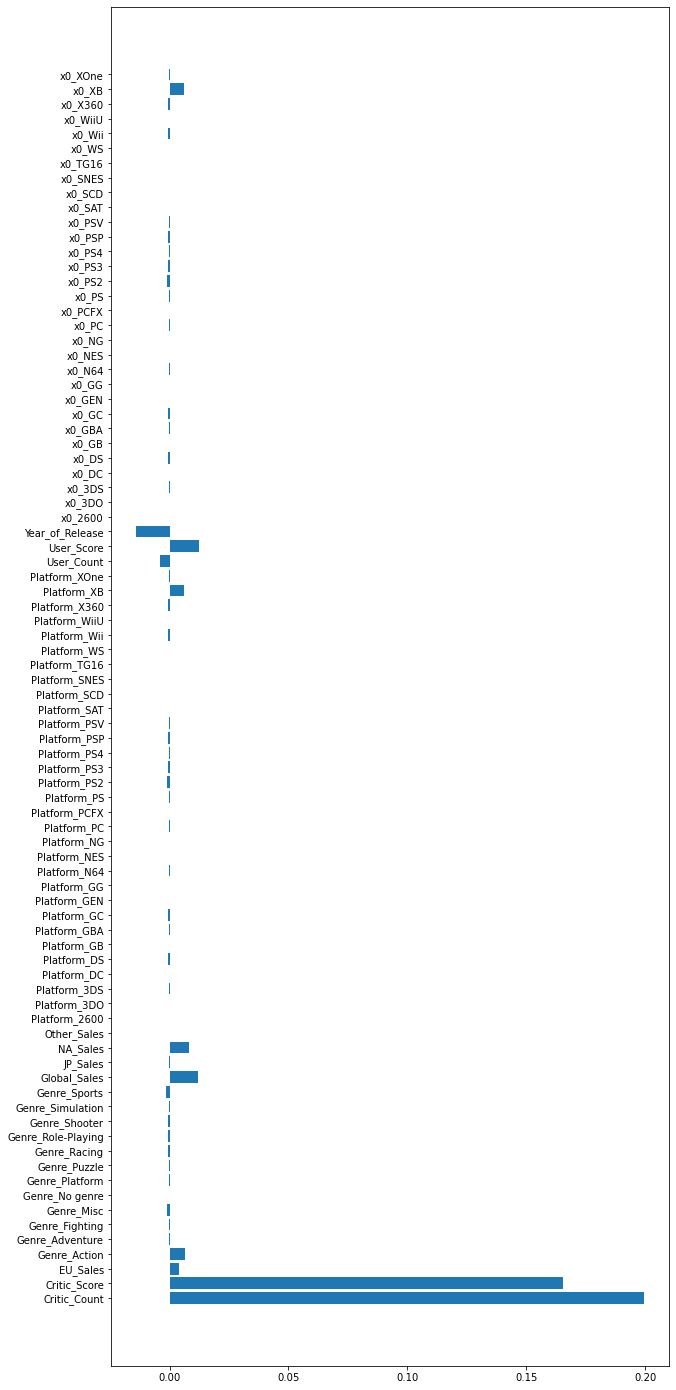

In [678]:
fig = plt.figure(figsize=[10, 25])
plt.barh(coefs_arr[:, 0], coefs_arr[:, 1].astype(float))
plt.show()

## Интересные ссылки (для тех, кто хочет знать еще больше!)

Приведу вам парочку просто интересных ссылок (которые, впрочем, расширяют кругозор знаний, но вряд ли помогут с выполнением домашки):
https://github.com/alicezheng/feature-engineering-book/blob/master/07.00_Swiss_roll.ipynb
https://habr.com/ru/company/mailru/blog/346942/